In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tifffile


In [54]:
x = tifffile.imread('/media/micro-nas-1/Bullock_lab/Yaiza/13:12:22/221115 BicD2-L790A-GFP HeLa FXR2 647 G3BP1 555 +As.lsm')
x.shape

(5, 4, 1912, 1912)

In [40]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
import pandas as pd

def manders_coefficients(mask1,mask2,im1=1,im2=1):
    """Compute Manders overlap coefficients"""
    intersect = np.logical_and(mask1, mask2)
    n1 = np.sum(mask1 * im1, dtype=float)
    n2 = np.sum(mask2 * im2, dtype=float)
    m1 = np.sum(intersect * im1, dtype=float) / n1 if n1 > 0 else 0
    m2 = np.sum(intersect * im2, dtype=float) / n2 if n2 > 0 else 0
    return ( m1, m2 )

def colocalization(images, masks):
    result = []
    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            union = np.logical_and(masks[i], masks[j])
            pcc = pearsonr(images[i][union], images[j][union])[0]
            scc = spearmanr(images[i][union], images[j][union])[0]
            mcc = manders_coefficients(masks[i], masks[j], images[i], images[j])
            result.append({
                'index 1': i,
                'index 2': j,
                'Pearson correlation coefficient' : pcc, 
                'Spearman correlation coefficient' : scc,
                'Manders correlation coefficient 1:2': mcc[0],
                'Manders correlation coefficient 2:1': mcc[1],
                })
    return result

res = colocalization(x[0],[im>10 for im in x[0]])

pd.DataFrame.from_records(res)


,index 1,index 2,Pearson correlation coefficient,Spearman correlation coefficient,Manders correlation coefficient 1:2,Manders correlation coefficient 2:1
0,0,1,-0.393193,-0.497439,0.278523,0.153279
1,0,2,-0.121308,-0.039479,0.056629,0.104638
2,0,3,-0.185655,-0.167286,0.368351,0.195482
3,1,2,0.009880,0.062885,0.424510,0.827922
4,1,3,0.120257,0.131614,0.614022,0.762547
5,2,3,0.828574,0.583806,0.871322,0.575091


array([16, 47, 50, ..., 19, 27, 17], dtype=uint8)

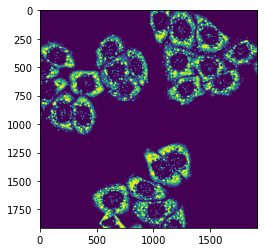

In [27]:
import matplotlib.pyplot as plt
plt.imshow(x[0,2]>10)
I1 = x[0,2]
M1 = x[0,2] > 10
I2 = x[0,3]
M2 = x[0,3] > 10
I2[M2]


In [16]:
import tifffile
tif = tifffile.TiffFile('/media/micro-nas-1/Bullock_lab/Yaiza/13:12:22/221115 BicD2-L790A-GFP HeLa FXR2 647 G3BP1 555 +As.lsm')
filename = '/media/micro-nas-1/Bullock_lab/Yaiza/13:12:22/221115 BicD2-L790A-GFP HeLa FXR2 647 G3BP1 555 +As.lsm'
with tifffile.TiffFile(filename) as tif:
    md = tif.lsm_metadata

md['VoxelSizeZ']*1e9

1e-10

In [42]:
import sganalysiswf as sga
from pathlib import Path
folder = Path('/media/micro-nas-1/Bullock_lab/Yaiza/13:12:22/')
L = sga.scan_folder_lsm(folder)
n = L['channels'][0]

config = {
    'Channels':['A','B','C','D'],
    'Nuclei': ['A','A'],
    'Cells': ['A','B'],
    'Particles':['C']
}


In [50]:

c = [config['channels'].index(c) for c in config['Particles']]
sga.segment_granules(im[c])

c = [config['channels'].index(c) for c in config['Nuclei']]
c


  Segmenting granule


[0, 0]

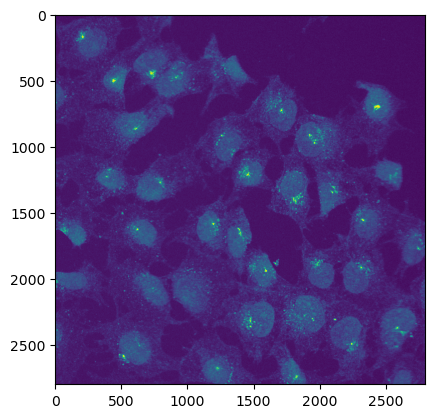

In [34]:
import matplotlib.pyplot as plt
import numpy as np
im,p = sga.load_image(L['filename'][5],0)
plt.imshow(np.amax(im[1:],axis=0))

  Segmenting cells
  done


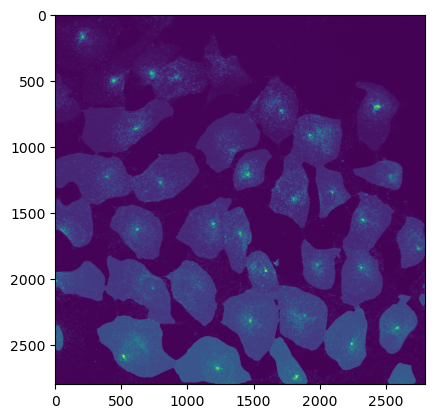

In [35]:
m = sga.segment_cells(im, p, 20)
plt.imshow(m+im[1])

In [ ]:
import pandas as pd
import sganalysiswf as sga
cells = pd.read_csv('/media/cephfs/data/GFP-488 FXR1-555 G3BP1-647/results/cells.csv')
a = cells.columns.tolist().index('Cell ID')+1
b = cells.columns.tolist().index('Number of nuclei')+2
sga.facet_plot(cells, cells.columns[a:b], 4)
#cells.hist('Area of the whole cell [px^2]')
#a = cells['Area of the whole cell [px^2]'].median()
#plt.plot([a,a],[0,600])


In [9]:
import json
config = json.load(open('/media/cephfs/data/GFP-488 FXR1-555 G3BP1-647/config.json','r'))
filelist = pd.read_csv( '/media/cephfs/data/GFP-488 FXR1-555 G3BP1-647/filelist.csv')
stats, mip, labels, rois = sga.process_fov('/media/cephfs/data/GFP-488 FXR1-555 G3BP1-647/'+filelist['filename'][0],1,config)



Segmenting images
  Segmenting cells
  done
  Segmenting nuclei
  Segmenting granule
  Segmenting granule


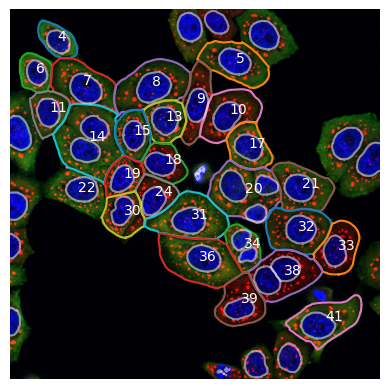

In [91]:
import matplotlib.pyplot as plt
#sga.show_roi(rois[5],mip,labels)
#plt.imshow(rois['granule'])
len(rois)
sga.show_image(mip,labels,rois)

(array([5., 5., 3., 2., 5., 3., 1., 2., 0., 1.]),
 array([ 26222. ,  33739.1,  41256.2,  48773.3,  56290.4,  63807.5,
         71324.6,  78841.7,  86358.8,  93875.9, 101393. ]),
 <BarContainer object of 10 artists>)

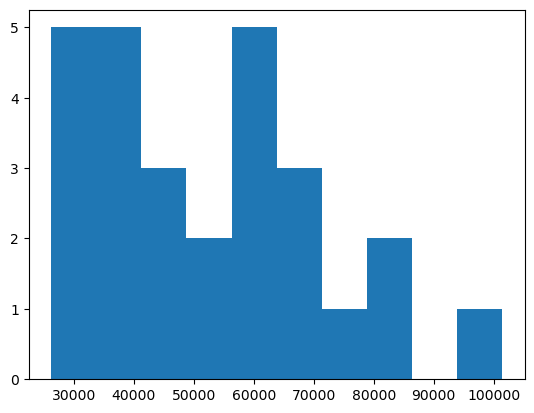

In [92]:
a = [x.area for x in rois]
import numpy as np
plt.hist(a)

In [89]:
#i,p=sga.load_image('/media/cephfs/data/GFP-488 FXR1-555 G3BP1-647/'+filelist['filename'][0],1)
r=0.1*50*1e3/p[1]
3.14159*r*r

6355.519270355074

In [14]:
import json
from pathlib import Path
import pandas as pd
import sganalysiswf as sga
folder = Path('/media/cephfs/data/GFP-488 FXR1-555 G3BP1-647')
filelist = pd.read_csv(folder / 'filelist.csv')
config = json.load(open(folder / 'config.json','r'))
imgidx=32
stats, mip, labels, rois = sga.process_fov(folder / filelist['filename'][imgidx],filelist['fov'][imgidx],config)
#sga.show_image(mip,labels,rois)


Segmenting images
  Segmenting cells
  done
  Segmenting nuclei
  Segmenting granule
  Segmenting granule


Text(0.5, 1.0, 'GFP')

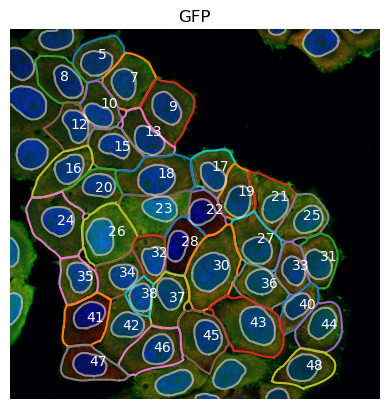

In [12]:
import matplotlib.pyplot as plt
sga.show_image(mip,labels,rois)
plt.title(filelist['condition'][imgidx])

In [17]:
import matplotlib.pyplot as plt
cellidx=2
ma,cr = sga.compute_roi_masks(rois[[x.label for x in rois].index(cellidx)],labels, mip)
plt.imshow((ma['particle']>0))#+2*(ma['other']>0))
#plt.imshow(cr['other'])

ValueError: 2 is not in list

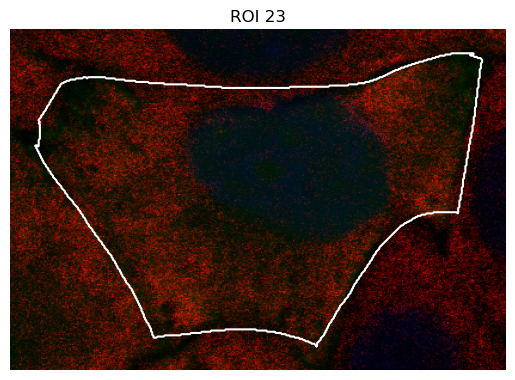

In [16]:
idx = 23
sga.show_roi(rois[[x.label for x in rois].index(idx)], mip, labels)

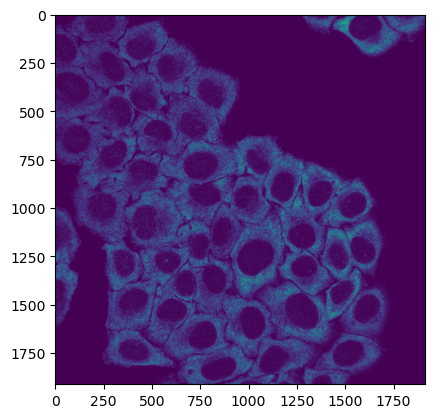

In [111]:
plt.imshow(mip['granule'])

In [ ]:
cells=[]
filelist = pd.read_csv(folder / 'filelist.csv',index_col='index')
for k in range(len(filelist)):
    try:
        cells.append(pd.read_csv(folder/'results'/f'cells{k:06d}.csv'))
    except:
        print(f'missing {k}')

cells = pd.concat(cells)
cells = cells.join(filelist,on='index')
cells


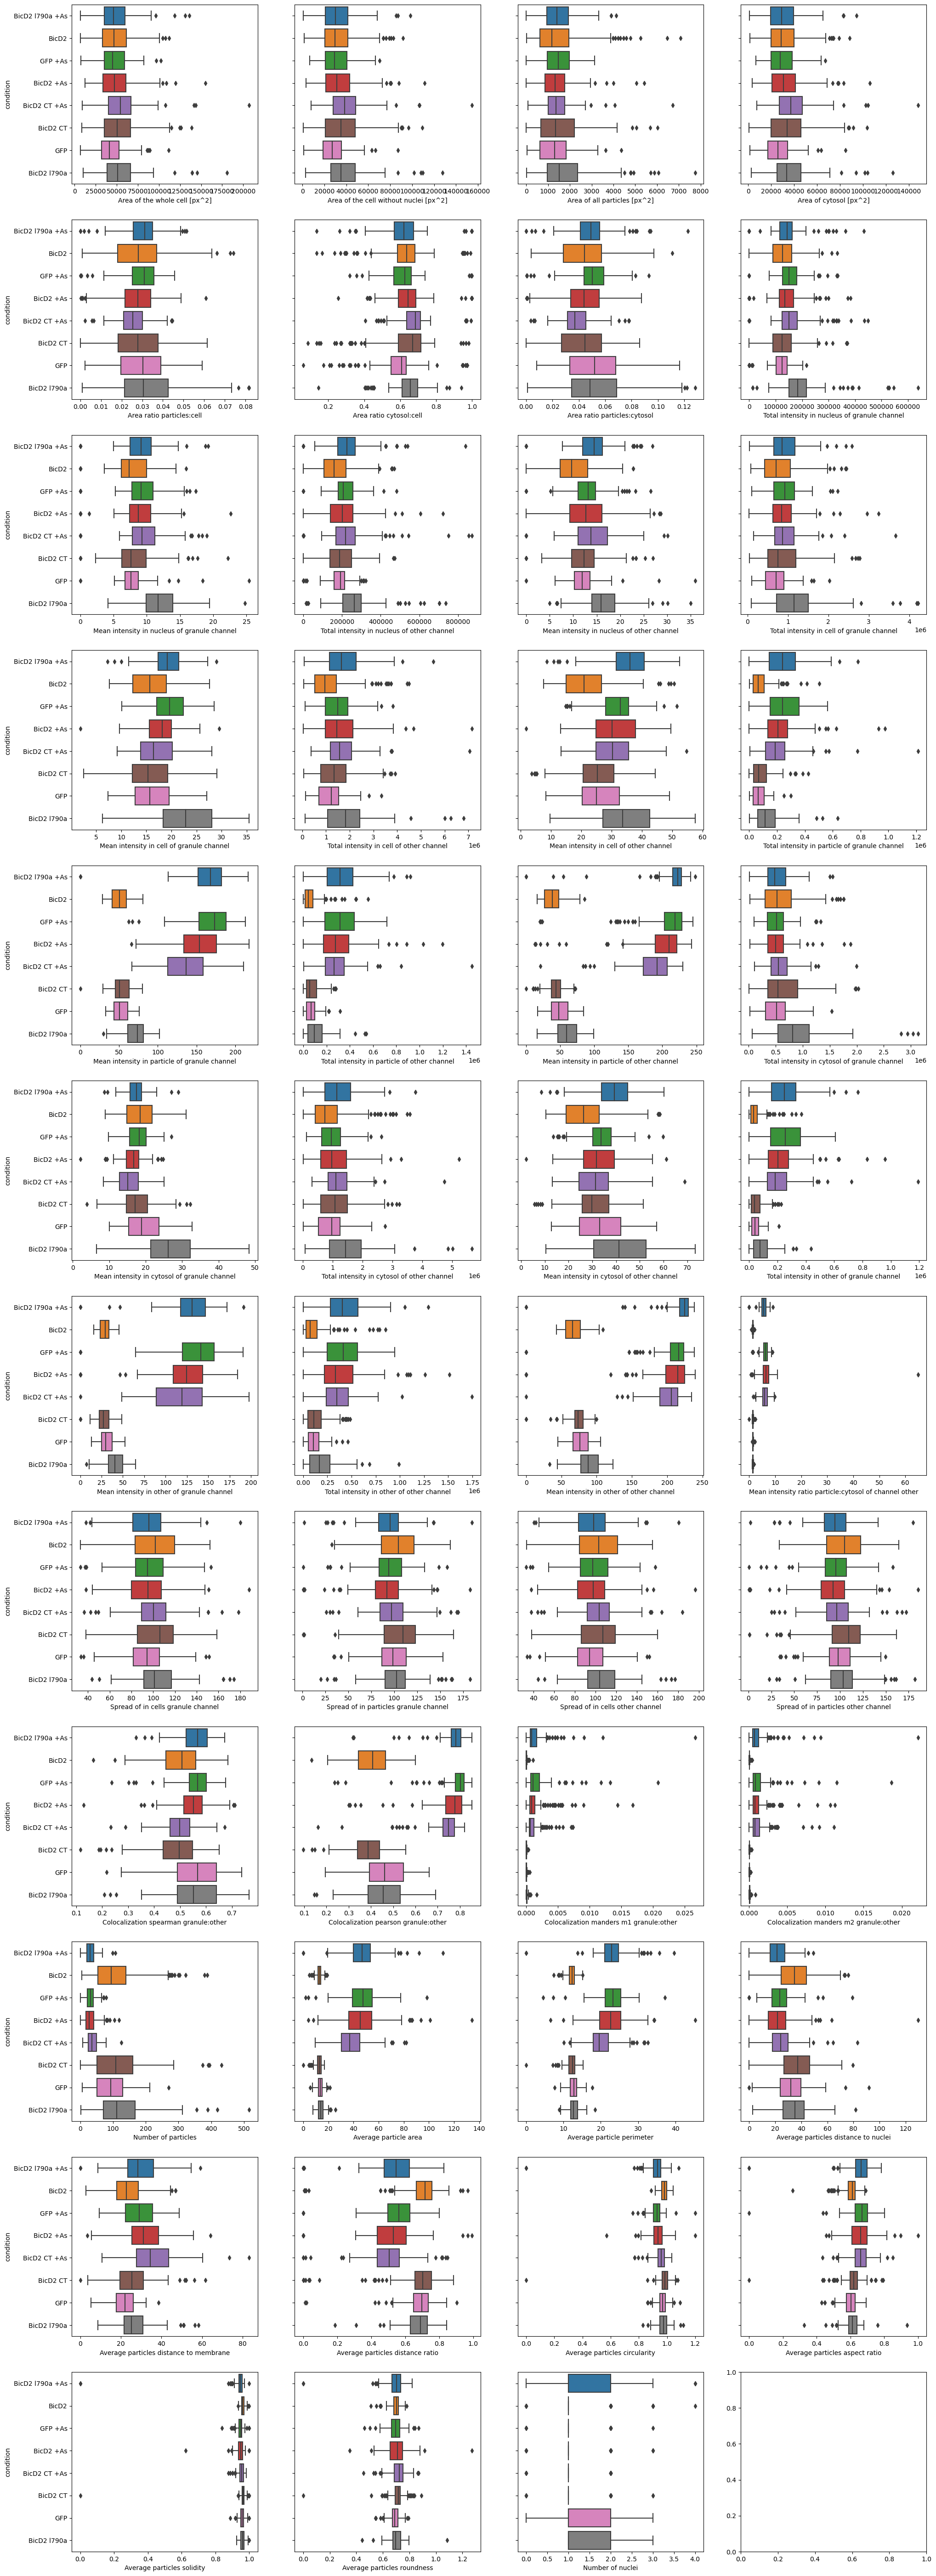

In [79]:
a = cells.columns.tolist().index('Cell ID')+1
b = cells.columns.tolist().index('Number of nuclei')+2
sga.facet_plot(cells, cells.columns[a:b], 4)